In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [2]:
!pip install accelerate
!pip install diffusers
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import timeit

import json


# Hyperparameters

In [4]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4 # 1e-4
NUM_EPOCHS = 524
NUM_GENERATE_IMAGES = 200
NUM_TIMESTEPS = 4000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"


# Pathes

In [5]:
#  dataname = "Pneumonia"
dataname = "COVID" #  or dataname = "Pneumonia"
dir_path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch"
save_path = f"{dir_path}/save_model/BATCHSIZE{BATCH_SIZE}_TIMESTEPS{NUM_TIMESTEPS}_EPOCHS{NUM_EPOCHS}_LEARNING_RATE{LEARNING_RATE}_checkpoint_{dataname}.pth"


# Load dataset

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

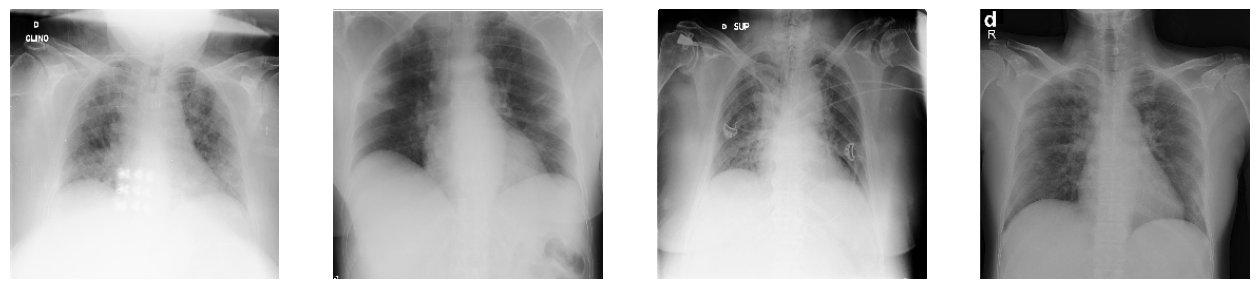

In [6]:
dataset = load_dataset(f"{dir_path}/chest_X_ray_covid", split="train", trust_remote_code=True)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [7]:

preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)


train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


# U-Net

In [8]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [9]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("U-NET: Input shape", sample_image.shape)
print("U-NET: Output shape", model(sample_image, timestep=0).sample.shape)

U-NET: Input shape torch.Size([1, 3, 128, 128])
U-NET: Output shape torch.Size([1, 3, 128, 128])


In [10]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1944, grad_fn=<MseLossBackward0>)


In [11]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)


# Train the model


In [ ]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)
# PYTORCH_NO_CUDA_MEMORY_CACHING=1

start = timeit.default_timer()

training_metrics = {
    'losses': [],
    'mses': [],
    'learning_rates': [],
}

for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    mse_sum = 0  # Initialize sum of MSE for the epoch
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        train_running_loss += loss.item()
        mse_sum += F.mse_loss(noise_pred, noise, reduction='sum').item()
    train_loss = train_running_loss / (idx+1)
    # mse_epoch = mse_sum / (idx + 1) * BATCH_SIZE  # Assuming each batch has BATCH_SIZE samples
    mse_epoch = mse_sum / (len(train_dataloader.dataset))  # Adjust this based on how you calculate MSE

    # Append the metrics for the current epoch to the dictionary
    training_metrics['losses'].append(train_loss)
    training_metrics['mses'].append(mse_epoch)
    training_metrics['learning_rates'].append(lr_scheduler.get_last_lr()[0])
    # print("-"*30)
    # print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    # print(f"Train MSE EPOCH: {epoch+1}: {mse_epoch:.4f}")

    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {train_running_loss}: {idx+1}")
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    # if epoch%10 == 0:
    #     sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")


# dir_path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch/save_model"

# Check if the directory exists, if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

filename = f"{dir_path}/training_metrics_BATCHSIZE{BATCH_SIZE}_TIMESTEPS{NUM_TIMESTEPS}_EPOCHS{NUM_EPOCHS}_LEARNING_RATE{LEARNING_RATE}_{dataname}.json"

# Save the metrics to the file
with open(filename, 'w') as f:
    json.dump(training_metrics, f)

print(f"Metrics saved to {filename}")

  0%|          | 1/524 [20:19<177:05:54, 1219.03s/it]

------------------------------
Train Loss EPOCH: 15.42995011806488: 13
Train Loss EPOCH: 1: 1.1869
Train Learning Rate EPOCH: 1: 2.6e-06
------------------------------


  0%|          | 2/524 [40:25<175:42:00, 1211.73s/it]

------------------------------
Train Loss EPOCH: 13.823550820350647: 13
Train Loss EPOCH: 2: 1.0634
Train Learning Rate EPOCH: 2: 5.2e-06
------------------------------


 46%|████▌     | 6/13 [09:37<11:12, 96.10s/it]

# Saving checkpoints


In [ ]:
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": lr_scheduler.state_dict(),
}

# Define your save path
# save_path = f"{dir_path}/BATCHSIZE{BATCH_SIZE}_TIMESTEPS{NUM_TIMESTEPS}_EPOCHS{NUM_EPOCHS}_checkpoint_{dataname}.pth"

# Save checkpoint
torch.save(checkpoint, save_path)


# Load the checkpoint

In [ ]:
checkpoint = torch.load(save_path)

# Load states into the model, optimizer, and scheduler
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
lr_scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

# If you're resuming training and need to prepare these components with Accelerator again
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)


# Generate Images

In [ ]:
def sample_image_generation2(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir, dataname):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        # generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    for i, image in enumerate(images):
        if not os.path.exists(save_dir):
            # If the directory does not exist, create it
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, f"generated_image_{dataname}_{i+1}.png")
        if not isinstance(image, Image.Image):
            # Convert tensor image to PIL Image only if necessary
            pil_image = transforms.ToPILImage()(image)
        else:
            # If it's already a PIL image, no need to convert
            pil_image = image
        pil_image.save(save_path)

    fig = plt.figure()
    # for i in range(1, num_generate_images+1):
    for i in range(1, 10):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

In [ ]:
NUM_GENERATE_IMAGES = 100
RANDOM_SEED = 42
save_dir = f"{dir_path}/save_images_BATCHSIZE{BATCH_SIZE}_TIMESTEPS{NUM_TIMESTEPS}_EPOCHS{NUM_EPOCHS}_{dataname}"
sample_image_generation2(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS, save_dir, dataname)

  0%|          | 0/4000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 600.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 575.06 MiB is free. Process 1101613 has 14.18 GiB memory in use. Of the allocated memory 13.26 GiB is allocated by PyTorch, and 806.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)